## Imports the MovieLens-100K dataset

In [1]:
# download ml-100k dataset from the official website:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip; unzip ml-100k.zip

--2023-03-23 13:51:01--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  11.4MB/s    in 0.4s    

2023-03-23 13:51:01 (11.4 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [2]:
%matplotlib inline

import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# set random seed
seed = 42
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Data Processing

There are several pre-defined training and validation set from the `ml-100k` dataset. We will use the split where each user has exactly 10 ratings in the test set(`ua.base` and `ua.test`). The training set consists of 90,570 user-item-rating tuples and the validation set consists of 9,430 such tuples.

In [4]:
user_cnts = 943     # total number of users
item_cnts = 1682    # total number of items

In [5]:
# we fisrt tranform the user and item index to start from 0.

def get_dfs():
    train_df = pd.read_csv("ml-100k/ua.base", sep='\t', header=None)
    train_df.columns = ['user_id','item_id','rating','ts']
    train_df['user_id'] = train_df['user_id'] -1 
    train_df['item_id'] = train_df['item_id'] -1
    valid_df = pd.read_csv("ml-100k/ua.test", sep='\t', header=None)
    valid_df.columns = ['user_id','item_id','rating','ts']
    valid_df['user_id'] = valid_df['user_id'] -1 
    valid_df['item_id'] = valid_df['item_id'] -1
    return train_df, valid_df

train_df, valid_df = get_dfs()
train_df.shape, valid_df.shape

((90570, 4), (9430, 4))

In [6]:
# check number of unique users in both training and test set
train_users = train_df.user_id.unique()
valid_users = valid_df.user_id.unique()
len(train_users), len(valid_users)

(943, 943)

In [7]:
train_items = train_df.item_id.unique()
valid_items = valid_df.item_id.unique()
len(train_items), len(valid_items)

(1680, 1129)

In [8]:
len([u for u in valid_items if u in train_items])

1127

## Dataset

In [9]:
class MovieLensDataset(Dataset):
    def __init__(self, df, user_col=0, item_col=1, rating_col=2):
        self.df = df
        self.user_tensor = torch.tensor(self.df.iloc[:,user_col], dtype=torch.long)
        self.item_tensor = torch.tensor(self.df.iloc[:,item_col], dtype=torch.long)
        self.target_tensor = torch.tensor(self.df.iloc[:,rating_col], dtype=torch.float32)
        
    def __getitem__(self, index):
        return(self.user_tensor[index], self.item_tensor[index], self.target_tensor[index])

    def __len__(self):
        return(self.target_tensor.shape[0])

In [10]:
batch_size = 1000
train_df, valid_df = get_dfs()
train_ds = MovieLensDataset(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [11]:
len(train_ds), len(valid_ds), len(train_dl), len(valid_dl)

(90570, 9430, 91, 10)

In [12]:
train_ds[:5], valid_ds[:20]

((tensor([0, 0, 0, 0, 0]),
  tensor([0, 1, 2, 3, 4]),
  tensor([5., 3., 4., 3., 3.])),
 (tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  tensor([ 19,  32,  60, 116, 154, 159, 170, 188, 201, 264,  12,  49, 250, 279,
          280, 289, 291, 296, 311, 313]),
  tensor([4., 4., 4., 3., 2., 4., 5., 3., 5., 4., 4., 5., 5., 3., 3., 3., 4., 4.,
          3., 1.])))

In [13]:
user_sample, item_sample, target_sample = next(iter(train_dl))
user_sample.shape, item_sample.shape, target_sample.shape

(torch.Size([1000]), torch.Size([1000]), torch.Size([1000]))

## Collaborative Filtering

### Architecture

The simplest form of collaborative filtering consists of the following elements:

1. **Item Embedding Layer** to convert item index to vectors
2. **User Embedding Layer** to convert user index to vectors
3. **Item Bias** to be added to the dot product
4. **User Bias** to be added to the dot product

We feed each pair of user and item indice into the layers above the perform the following operations to get the predicted rating:

$$rating_{predicted}=\sum{(E_{item} * E_{user})} + B_{user} + B_{item}$$

where $E$ stands for embedding activations and $B$ for biases.

In [14]:
class CF(nn.Module):
    def __init__(self, config):
        super(CF, self).__init__()
       
        # hyper-parameters
        self.config = config
        self.nb_users = config['user_cnts']
        self.nb_items = config['item_cnts']
        self.emb_dim = config['emb_dim']
        self.y_range = config['y_range']

        # embeddings
        self.emb_user = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=self.emb_dim)
        self.user_bias = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=1)
        self.emb_item = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_dim)
        self.item_bias = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=1)
        

    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx)  # dim: (batch_size, embed_dim)
        item_emb = self.emb_item(item_idx)  # dim: (batch_size, embed_dim)
        dot = (user_emb * item_emb).sum(1)  # dim: (batch_size)
        x = dot + self.user_bias(user_idx).squeeze() + self.item_bias(item_idx).squeeze()
        x = torch.sigmoid(x)                # dim: (batch_size)
        x = x * (self.y_range[1] - self.y_range[0]) + self.y_range[0]
        return x

In [15]:
model_config = {
    'user_cnts': 943,       # unique users for embedding layer
    'item_cnts': 1682,      # unique items for embedding layer
    'emb_dim': 100,         # size of embedding vector
    'y_range': [1.0, 5.0]   # range of output
}
model = CF(model_config)
model

CF(
  (emb_user): Embedding(943, 100)
  (user_bias): Embedding(943, 1)
  (emb_item): Embedding(1682, 100)
  (item_bias): Embedding(1682, 1)
)

### Puting things together and train the model!

In [16]:

def train_cf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=True):

    # for recording training output
    train_loss = 0
    valid_loss = 0
    train_losses = []
    valid_losses = []
    best_loss = np.inf
    best_weights = None

    # train for a given amount of epochs
    for e in tqdm(range(epochs)): 
        
        # start batch training
        model.train()
        for u, i, r in train_dl:
            # send data to device
            u, i, r = u.to(device), i.to(device), r.to(device)
            # model prediction
            r_pred = model(u, i)
            # compute loss
            loss = loss_fn(r_pred, r)
            # back prop
            optim.zero_grad()
            loss.backward()
            optim.step()
            train_loss+= loss.detach().item()
    
        # record loss
        train_loss /= len(train_ds)     # average loss over all examples.
        train_losses.append(train_loss)
        
        #validation
        model.eval()                    # this fix the trainable parameters.
        for u, i, r in valid_dl:
            u, i, r = u.to(device), i.to(device), r.to(device)
            r_pred = model(u, i)
            loss = loss_fn(r_pred, r)
            valid_loss += loss.detach().item()
    
        valid_loss /= len(valid_ds)
        valid_losses.append(valid_loss)
        
        if verbose:
            print(f'Epoch {e} Train loss: {train_loss:.4f}; Valid loss: {valid_loss:.4f}')

        # choose best model
        if valid_loss < best_loss:
            best_loss = valid_loss
            # you can save the current best model parameters for further training:
            # best_weights = copy.deepcopy(model.state_dict())
    
    return train_losses, valid_losses

In [17]:
# hyperparameters
batch_size = 1000   # batch size
lr = 1e-2           # learning rate
epochs = 50         # epochs to train
weight_decay = 0    # L2 penalty (very important for this task)

model_config = {
    'user_cnts': 943,       # unique users for embedding layer
    'item_cnts': 1682,      # unique items for embedding layer
    'emb_dim': 100,         # size of embedding vector
    'y_range': [1.0, 5.0]   # range of model predictions
}

# datasets/dataloaders
train_df, valid_df = get_dfs()
train_ds = MovieLensDataset(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# CF model
model = CF(model_config).to(device)
loss_fn = nn.MSELoss(reduction='sum')
optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

# training func
train_losses, valid_losses = train_cf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=False)

  0%|          | 0/50 [00:00<?, ?it/s]

Best RMSE: 2.0417201681651815


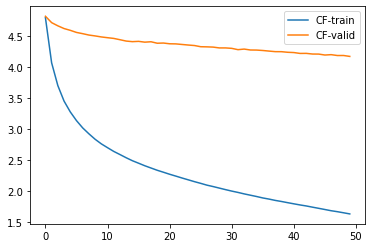

In [23]:
# plot losses
plt.plot(train_losses, label='CF-train')
plt.plot(valid_losses, label='CF-valid')
plt.legend()
print(f'Best RMSE: {np.sqrt(min(valid_losses))}')

#### Item Embeddings

The useful thing about having item bias is that we can use it to rank our items, in this case, movies. Movies with more positive bias values are considered to be the "better" ones.

In [24]:
item_df = pd.read_csv("ml-100k/u.item", delimiter='|', encoding='latin-1', header=None,
                      names=['item_id', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
item_df = item_df[['item_id','title']].copy()
item_df['item_id'] = item_df.item_id.map(lambda x: int(x)-1)
item_df.head()

,item_id,title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)


In [25]:
movie_ranking = []
for item_id in model.item_bias.weight.data.squeeze().argsort().cpu().numpy():
    movie_ranking.append((item_df.iloc[item_id,1],model.item_bias.weight.data[item_id].item()))

In [26]:
# best rated movies
movie_ranking[::-1][:10]

[('Princess Bride, The (1987)', 4.815973281860352),
 ('Casablanca (1942)', 4.638743877410889),
 ('Star Wars (1977)', 4.435879707336426),
 ('Godfather, The (1972)', 4.380758285522461),
 ('To Kill a Mockingbird (1962)', 3.9683144092559814),
 ('Raiders of the Lost Ark (1981)', 3.7875638008117676),
 ('Evil Dead II (1987)', 3.7648439407348633),
 ('Shawshank Redemption, The (1994)', 3.7636163234710693),
 ('Alien (1979)', 3.525956392288208),
 ('Fargo (1996)', 3.4436867237091064)]

In [27]:
# worst rated movies
movie_ranking[:10]

[('T-Men (1947)', -3.130326747894287),
 ('Tom & Viv (1994)', -2.7318506240844727),
 ('Stripes (1981)', -2.7157440185546875),
 ('Geronimo: An American Legend (1993)', -2.5751771926879883),
 ('Catwalk (1995)', -2.4910004138946533),
 ('Office Killer (1997)', -2.441242218017578),
 ('Anaconda (1997)', -2.4053242206573486),
 ('Mouse Hunt (1997)', -2.375096559524536),
 ("National Lampoon's Senior Trip (1995)", -2.374380588531494),
 ('Jeffrey (1995)', -2.3575856685638428)]

## Question 1

### Q1 - (a)

In [28]:
# [CF]: best embedding dimension (SGD)

# hyperparameters
batch_size = 1000   # batch size
lr = 1e-2           # learning rate
epochs = 100        # epochs to train
weight_decay = 0    # L2 penalty (very important for this task)

# datasets/dataloaders
train_df, valid_df = get_dfs()
train_ds = MovieLensDataset(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# running experiments
valid_losses_dict = {}
for ebd_size in [10, 50, 100]:
    # build a CF model
    model_config = {
        'user_cnts': 943,       # unique users for embedding layer
        'item_cnts': 1682,      # unique items for embedding layer
        'emb_dim': ebd_size,    # size of embedding vector
        'y_range': [1.0, 5.0]   # range of model predictions
    }
    model = CF(model_config).to(device)
    # init loss func & optimizer
    loss_fn = nn.MSELoss(reduction='sum')
    optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    # training
    train_losses, valid_losses = train_cf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=False)
    valid_losses_dict[ebd_size] = valid_losses
    print(f'[emd_size = {ebd_size}]: Best RMSE = {np.sqrt(min(valid_losses))}')

  0%|          | 0/100 [00:00<?, ?it/s]

[emd_size = 10]: Best RMSE = 1.161720930803303


  0%|          | 0/100 [00:00<?, ?it/s]

[emd_size = 50]: Best RMSE = 1.7177394568349544


  0%|          | 0/100 [00:00<?, ?it/s]

[emd_size = 100]: Best RMSE = 1.9824791265776178


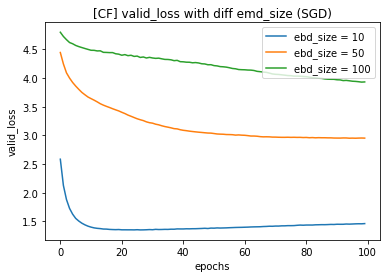

In [29]:
plt.title('[CF] valid_loss with diff emd_size (SGD)')
plt.xlabel('epochs')
plt.ylabel('valid_loss')
for k, v in valid_losses_dict.items():
    plt.plot(v, label=f'ebd_size = {k}')
plt.legend()

In [30]:
# [CF]: best embedding dimension (Adam)

# hyperparameters
batch_size = 1000   # batch size
lr = 1e-3           # learning rate
epochs = 100        # epochs to train
weight_decay = 0    # L2 penalty (very important for this task)

# datasets/dataloaders
train_df, valid_df = get_dfs()
train_ds = MovieLensDataset(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# running experiments
valid_losses_dict = {}
for ebd_size in [10, 50, 100]:
    # build a CF model
    model_config = {
        'user_cnts': 943,       # unique users for embedding layer
        'item_cnts': 1682,      # unique items for embedding layer
        'emb_dim': ebd_size,    # size of embedding vector
        'y_range': [1.0, 5.0]   # range of model predictions
    }
    model = CF(model_config).to(device)
    # init loss func & optimizer
    loss_fn = nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # training
    train_losses, valid_losses = train_cf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=False)
    valid_losses_dict[ebd_size] = valid_losses
    print(f'[emd_size = {ebd_size}]: Best RMSE = {np.sqrt(min(valid_losses))}')

  0%|          | 0/100 [00:00<?, ?it/s]

[emd_size = 10]: Best RMSE = 1.1704041198226505


  0%|          | 0/100 [00:00<?, ?it/s]

[emd_size = 50]: Best RMSE = 1.9513213329937393


  0%|          | 0/100 [00:00<?, ?it/s]

[emd_size = 100]: Best RMSE = 2.153307695610467


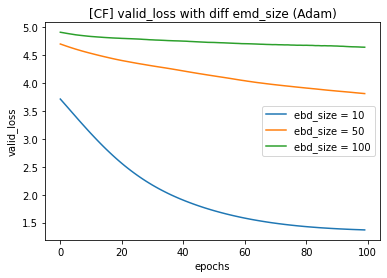

In [31]:
plt.title('[CF] valid_loss with diff emd_size (Adam)')
plt.xlabel('epochs')
plt.ylabel('valid_loss')
for k, v in valid_losses_dict.items():
    plt.plot(v, label=f'ebd_size = {k}')
plt.legend()

By the experiment results, ebd_size = 10 generally gives the best performance.

### Q1 - (b)

In [32]:
# [CF]: best learning rate (Adam)

# hyperparameters
batch_size = 1000   # batch size
lr = 'TBD'          # learning rate
epochs = 'TBD'      # epochs to train
weight_decay = 0    # L2 penalty (very important for this task)

# datasets/dataloaders
train_df, valid_df = get_dfs()
train_ds = MovieLensDataset(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# running experiments
valid_losses_dict = {}
for lr, epochs in zip([1e-1, 1e-2, 1e-3], [50, 100, 200]):
    # build a CF model
    model_config = {
        'user_cnts': 943,       # unique users for embedding layer
        'item_cnts': 1682,      # unique items for embedding layer
        'emb_dim': 10,          # size of embedding vector
        'y_range': [1.0, 5.0]   # range of model predictions
    }
    model = CF(model_config).to(device)
    # init loss func & optimizer
    loss_fn = nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # training
    train_losses, valid_losses = train_cf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=False)
    valid_losses_dict[lr] = valid_losses
    print(f'[lr = {lr}]: Best RMSE = {np.sqrt(min(valid_losses))}')

  0%|          | 0/50 [00:00<?, ?it/s]

[lr = 0.1]: Best RMSE = 1.211031978623613


  0%|          | 0/100 [00:00<?, ?it/s]

[lr = 0.01]: Best RMSE = 1.156278095641947


  0%|          | 0/200 [00:00<?, ?it/s]

[lr = 0.001]: Best RMSE = 1.1625913361982458


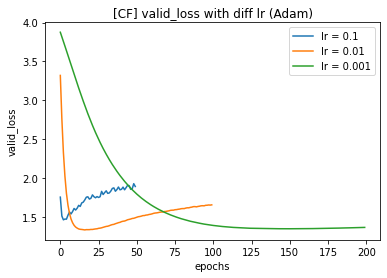

In [33]:
plt.title('[CF] valid_loss with diff lr (Adam)')
plt.xlabel('epochs')
plt.ylabel('valid_loss')
for k, v in valid_losses_dict.items():
    plt.plot(v, label=f'lr = {k}')
plt.legend()

By the experiment results, lr = 1e-2 generally gives the best performance. Besides, 50 epochs should be sufficient for convergence.

In [34]:
# [CF]: best weight decay (Adam)

# hyperparameters
batch_size = 1000       # batch size
lr = 1e-2               # learning rate
epochs = 50             # epochs to train
weight_decay = 'TBD'    # L2 penalty (very important for this task)

# datasets/dataloaders
train_df, valid_df = get_dfs()
train_ds = MovieLensDataset(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# running experiments
valid_losses_dict = {}
for wd in [0, 1e-2, 1e-1]:
    # build a CF model
    model_config = {
        'user_cnts': 943,       # unique users for embedding layer
        'item_cnts': 1682,      # unique items for embedding layer
        'emb_dim': 10,          # size of embedding vector
        'y_range': [1.0, 5.0]   # range of model predictions
    }
    model = CF(model_config).to(device)
    # init loss func & optimizer
    loss_fn = nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    # training
    train_losses, valid_losses = train_cf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=False)
    valid_losses_dict[wd] = valid_losses
    print(f'[weight_decay = {wd}]: Best RMSE = {np.sqrt(min(valid_losses))}')

  0%|          | 0/50 [00:00<?, ?it/s]

[weight_decay = 0]: Best RMSE = 1.1466486494281247


  0%|          | 0/50 [00:00<?, ?it/s]

[weight_decay = 0.01]: Best RMSE = 1.060392922849602


  0%|          | 0/50 [00:00<?, ?it/s]

[weight_decay = 0.1]: Best RMSE = 0.9464129906203018


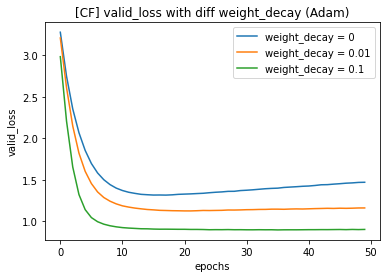

In [35]:
plt.title('[CF] valid_loss with diff weight_decay (Adam)')
plt.xlabel('epochs')
plt.ylabel('valid_loss')
for k, v in valid_losses_dict.items():
    plt.plot(v, label=f'weight_decay = {k}')
plt.legend()

By the experiment results, L2 regularizations can effectively improve the performance. weight_decay = 1e-1 gives the best result. \
\
To sum up, we adopt following configuration by default: \
- Adam optimizer
- lr = 1e-2
- num_epochs = 50
- weight_decay = 1e-1
- embedding_dim = 10

## Question 2

### Q2 - (a)

In [36]:
class GMF(nn.Module):
    def __init__(self, config):
        super().__init__()
       
        # hyper-parameters
        self.config = config
        self.emb_dim = config['emb_dim']
        self.nb_users = config['user_cnts']
        self.nb_items = config['item_cnts']

        # embedding layers
        self.emb_user = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=self.emb_dim)
        self.emb_item = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_dim)
        
    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx)  # (batch_size, embed_dim)
        item_emb = self.emb_item(item_idx)  # (batch_size, embed_dim)
        product = user_emb * item_emb       # (batch_size, embed_dim)
        return product

### Q2 - (b)

In [37]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
       
        # hyper-parameters
        self.config = config
        self.emb_dim = config['emb_dim']
        self.nb_users = config['user_cnts']
        self.nb_items = config['item_cnts']
        self.hidden_dims = config['hidden_dims']

        # embedding layers
        self.emb_user = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=self.emb_dim)
        self.emb_item = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_dim)
        
        # mlp layer
        layers = []
        in_dim = 2 * self.emb_dim
        for out_dim in self.hidden_dims:
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.ReLU(inplace=True))
            in_dim = out_dim
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx)          # (batch_size, embed_dim)
        item_emb = self.emb_item(item_idx)          # (batch_size, embed_dim)
        x = torch.cat((user_emb, item_emb), dim=1)  # (batch_size, 2*embed_dim)
        x = self.mlp(x)                             # (batch_size, hidden_dims[-1])
        return x

### Q2 - (c)

In [38]:
class NMF(nn.Module):
    def __init__(self, config):
        super().__init__()
       
        # hyper-parameters
        self.config = config
        self.emb_dim = config['emb_dim']
        self.hidden_dims = config['hidden_dims']
        self.dropout_flag = config['dropout_flag']

        # GMF component
        self.gmf = GMF(config)

        # MLP component
        self.mlp = MLP(config)

        # NeuMF layer
        self.nmf = nn.Sequential(
            nn.Linear(self.emb_dim+self.hidden_dims[-1], 1),
            nn.Dropout(p=0.2) if self.dropout_flag else nn.Identity(),
            nn.Sigmoid()
        )
        
    def forward(self, user_idx, item_idx):
        x_gmf = self.gmf(user_idx, item_idx)    # (batch_size, embed_dim)
        x_mlp = self.mlp(user_idx, item_idx)    # (batch_size, hidden_dim)
        x = torch.cat((x_gmf, x_mlp), dim=1)    # (batch_size, embed_dim+hidden_dims[-1])
        x = self.nmf(x)                         # (batch_size, 1)
        return x.squeeze()                      # (batch_size, )

### Q2 - (d)

In [39]:
def train_nmf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=True):

    # for recording training output
    train_loss = 0
    valid_loss = 0
    train_losses = []
    valid_losses = []
    best_loss = np.inf
    best_weights = None

    # train for a given amount of epochs
    for e in tqdm(range(epochs)): 
        
        # start batch training
        model.train()
        for u, i, r in train_dl:
            # transform ratings
            y = r.apply_(lambda x: 1 if x > 3 else 0)
            # send data to device
            u, i, y = u.to(device), i.to(device), y.to(device)
            # model prediction
            r_pred = model(u, i)
            # compute loss
            loss = loss_fn(r_pred, y)
            # back prop
            optim.zero_grad()
            loss.backward()
            optim.step()
            train_loss+= loss.detach().item()
    
        # record loss
        train_loss /= len(train_ds)     # average loss over all examples.
        train_losses.append(train_loss)
        
        #validation
        model.eval()                    # this fix the trainable parameters.
        for u, i, r in valid_dl:
            y = r.apply_(lambda x: 1 if x > 3 else 0)
            u, i, y = u.to(device), i.to(device), y.to(device)
            r_pred = model(u, i)
            loss = loss_fn(r_pred, y)
            valid_loss += loss.detach().item()
    
        valid_loss /= len(valid_ds)
        valid_losses.append(valid_loss)
        
        if verbose:
            print(f'Epoch {e} Train loss: {train_loss:.4f}; Valid loss: {valid_loss:.4f}')

        # choose best model
        if valid_loss < best_loss:
            best_loss = valid_loss
            # you can save the current best model parameters for further training:
            # best_weights = copy.deepcopy(model.state_dict())
    
    return train_losses, valid_losses

In [40]:
# [NMF]: best lr (Adam)

# hyperparameters
batch_size = 1000       # batch size
lr = 'TBD'              # learning rate
epochs = 'TBD'          # epochs to train (NMF converges much faster)
weight_decay = 0        # L2 penalty (very important for this task)

# datasets/dataloaders
train_df, valid_df = get_dfs()
train_ds = MovieLensDataset(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# running experiments
valid_losses_dict = {}
for lr, epochs in zip([1e-1, 1e-2, 1e-3], [10, 20, 40]):
    # build a NMF model
    model_config = {
        'user_cnts': 943,       # unique users for embedding layer
        'item_cnts': 1682,      # unique items for embedding layer
        'emb_dim': 10,          # size of embedding vector
        'hidden_dims': (10, ),  # hidden dims tuple
        'dropout_flag': False   # add a dropout layer (=> almost no difference)
    }
    model = NMF(model_config).to(device)
    # init loss func & optimizer
    loss_fn = nn.BCELoss(reduction='sum')
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # training
    train_losses, valid_losses = train_nmf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=False)
    valid_losses_dict[lr] = valid_losses
    print(f'[lr = {lr}]: Best RMSE = {np.sqrt(min(valid_losses))}')

  0%|          | 0/10 [00:00<?, ?it/s]

[lr = 0.1]: Best RMSE = 0.7636006402903046


  0%|          | 0/20 [00:00<?, ?it/s]

[lr = 0.01]: Best RMSE = 0.7642800571485633


  0%|          | 0/40 [00:00<?, ?it/s]

[lr = 0.001]: Best RMSE = 0.7706447784537592


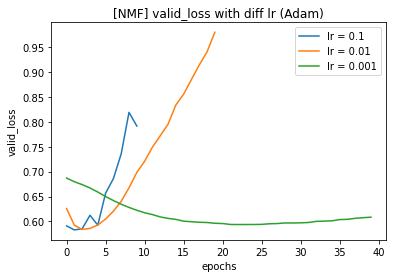

In [41]:
plt.title('[NMF] valid_loss with diff lr (Adam)')
plt.xlabel('epochs')
plt.ylabel('valid_loss')
for k, v in valid_losses_dict.items():
    plt.plot(v, label=f'lr = {k}')
plt.legend()

By the experiment results, lr = 1e-1 or lr = 1e-2 performs quite similar, then we still pick lr = 1e-2 by default. As NMF converges much faster, training for 20 epochs should be sufficient. 

In [43]:
# [NMF]: best weight decay (Adam)

# hyperparameters
batch_size = 1000       # batch size
lr = 1e-2               # learning rate
epochs = 20             # epochs to train (NMF converges much faster)
weight_decay = 'TBD'    # L2 penalty (very important for this task)

# datasets/dataloaders
train_df, valid_df = get_dfs()
train_ds = MovieLensDataset(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# running experiments
valid_losses_dict = {}
for wd in [0, 1e-2, 1e-1]:
    # build a NMF model
    model_config = {
        'user_cnts': 943,       # unique users for embedding layer
        'item_cnts': 1682,      # unique items for embedding layer
        'emb_dim': 10,          # size of embedding vector
        'hidden_dims': (10, ),  # hidden dims tuple
        'dropout_flag': False   # add a dropout layer (=> almost no difference)
    }
    model = NMF(model_config).to(device)
    # init loss func & optimizer
    loss_fn = nn.BCELoss(reduction='sum')
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    # training
    train_losses, valid_losses = train_nmf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=False)
    valid_losses_dict[wd] = valid_losses
    print(f'[wd = {wd}]: Best RMSE = {np.sqrt(min(valid_losses))}')

  0%|          | 0/20 [00:00<?, ?it/s]

[wd = 0]: Best RMSE = 0.7621775310951722


  0%|          | 0/20 [00:00<?, ?it/s]

[wd = 0.01]: Best RMSE = 0.7593430061951256


  0%|          | 0/20 [00:00<?, ?it/s]

[wd = 0.1]: Best RMSE = 0.7558463929071235


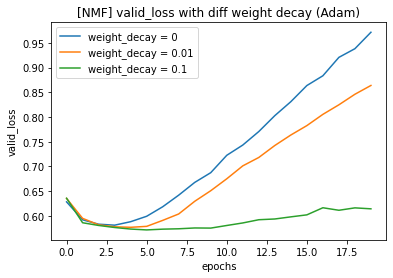

In [44]:
plt.title('[NMF] valid_loss with diff weight decay (Adam)')
plt.xlabel('epochs')
plt.ylabel('valid_loss')
for k, v in valid_losses_dict.items():
    plt.plot(v, label=f'weight_decay = {k}')
plt.legend()

By the experiment results,weight_decay = 1e-1 works the best. \
\
To sum up, we adopt following configuration by default: \
- Adam optimizer
- lr = 1e-2
- num_epochs = 20
- weight_decay = 1e-1
- embedding_dim = 10
- hidden dims = (10, )

In [45]:
# NMF: diff MLP layers (Adam)

# hyperparameters
batch_size = 1000       # batch size
lr = 1e-2               # learning rate
epochs = 20             # epochs to train
weight_decay = 1e-1     # L2 penalty (very important for this task)

# datasets/dataloaders
train_df, valid_df = get_dfs()
train_ds = MovieLensDataset(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# running experiments
valid_losses_dict = {}
for hds in [(10, ), (10, 10, )]:
    # build a NMF model
    model_config = {
        'user_cnts': 943,       # unique users for embedding layer
        'item_cnts': 1682,      # unique items for embedding layer
        'emb_dim': 10,          # size of embedding vector
        'hidden_dims': hds,     # hidden dims tuple
        'dropout_flag': False   # add a dropout layer (=> almost no difference)
    }
    model = NMF(model_config).to(device)
    print(model)
    # init loss func & optimizer
    loss_fn = nn.BCELoss(reduction='sum')
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # training
    train_losses, valid_losses = train_nmf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=False)
    valid_losses_dict[len(hds)] = valid_losses
    print(f'[hidden layers = {len(hds)}]: Best RMSE = {np.sqrt(min(valid_losses))}')

NMF(
  (gmf): GMF(
    (emb_user): Embedding(943, 10)
    (emb_item): Embedding(1682, 10)
  )
  (mlp): MLP(
    (emb_user): Embedding(943, 10)
    (emb_item): Embedding(1682, 10)
    (mlp): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (nmf): Sequential(
    (0): Linear(in_features=20, out_features=1, bias=True)
    (1): Identity()
    (2): Sigmoid()
  )
)


  0%|          | 0/20 [00:00<?, ?it/s]

[hidden layers = 1]: Best RMSE = 0.7558480877948991
NMF(
  (gmf): GMF(
    (emb_user): Embedding(943, 10)
    (emb_item): Embedding(1682, 10)
  )
  (mlp): MLP(
    (emb_user): Embedding(943, 10)
    (emb_item): Embedding(1682, 10)
    (mlp): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=10, out_features=10, bias=True)
      (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (nmf): Sequential(
    (0): Linear(in_features=20, out_features=1, bias=True)
    (1): Identity()
    (2): Sigmoid()
  )
)


  0%|          | 0/20 [00:00<?, ?it/s]

[hidden layers = 2]: Best RMSE = 0.7558716394488975


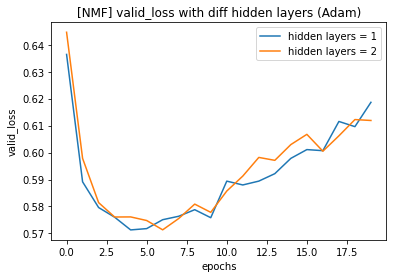

In [46]:
plt.title('[NMF] valid_loss with diff hidden layers (Adam)')
plt.xlabel('epochs')
plt.ylabel('valid_loss')
for k, v in valid_losses_dict.items():
    plt.plot(v, label=f'hidden layers = {k}')
plt.legend()

By the experiment results, the extra layer does not make a big difference, and the best RMSE is roughly the same. The results may vary if we adjust the size of hidden neurons or use a different random seed.

## Question 3

### Q3 - (a)

In [47]:
"""
sampling strategy:
 - pos: [rating > 3]
 - neg: [rating <= 3] OR [no interaction]
"""

class MovieLensDatasetWithTriplets(Dataset):
    def __init__(self, df, user_col=0, item_col=1, rating_col=2, neg_samples=5):
        # transfrom labels & filter training samples
        self.df = self.filter_df(df)
        self.neg_samples = neg_samples
        self.user_tensor = torch.tensor(self.df.iloc[:, user_col], dtype=torch.long)
        self.item_tensor = torch.tensor(self.df.iloc[:, item_col], dtype=torch.long)
        self.target_tensor = torch.tensor(self.df.iloc[:, rating_col], dtype=torch.float32)
        # pre-compute negative item set (nis)
        self.user_list = np.unique(self.df.iloc[:, user_col].values)
        self.item_list = np.unique(self.df.iloc[:, item_col].values)
        self.item_set_all = set(self.item_list)
        self.nis_dict = {u:self.neg_item_set(u) for u in self.user_list}

    @staticmethod
    def filter_df(df):
        df['rating'] = df['rating'].apply(lambda x: 1 if x > 3 else 0)
        return df[df['rating'] == 1]

    def neg_item_set(self, uid):
        pis = set(self.df[self.df['user_id'] == uid.item()]['item_id'].values)
        nis = self.item_set_all - pis
        return list(nis)
        
    def __getitem__(self, index):
        u, i = self.user_tensor[index], self.item_tensor[index]
        js = random.choices(self.nis_dict[u.item()], k=self.neg_samples)
        js = torch.tensor(js, dtype=torch.long)
        return u, i, js

    def __len__(self):
        return (self.target_tensor.shape[0])


In [48]:
batch_size = 1000
train_df, valid_df = get_dfs()
train_ds = MovieLensDatasetWithTriplets(train_df)
valid_ds = MovieLensDatasetWithTriplets(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

u, i, js = next(iter(train_dl))
u, i, js = u.to(device), i.to(device), js.to(device)
u.shape, i.shape, js.shape

(torch.Size([1000]), torch.Size([1000]), torch.Size([1000, 5]))

### Q3 - (b)

In [51]:
# reference: https://github.com/sh0416/bpr/blob/master/train.py#L68

class BPR(nn.Module):
    def __init__(self, config):
        super().__init__()
       
        # hyper-parameters
        self.config = config
        self.emb_dim = config['emb_dim']
        self.nb_users = config['user_cnts']
        self.nb_items = config['item_cnts']

        # embedding layers
        self.emb_user = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=self.emb_dim)
        self.emb_item = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_dim)

    def forward(self, u, i, js):
        # compute x_ui
        emb_u = self.emb_user(u)                        # (batch_size, embed_dim)
        emb_i = self.emb_item(i)                        # (batch_size, embed_dim)
        x_ui = torch.mul(emb_u, emb_i).sum(dim=1)       # (batch_size, )
        # compute x_uj for all js
        x_uj = 0
        for j in range(js.shape[-1]):
            emb_j = self.emb_item(js[:, j])             # (batch_size, embed_dim)
            x_uj += torch.mul(emb_u, emb_j).sum(dim=1)  # (batch_size, )
        x_uj /= js.shape[-1]                            # (batch_size, )
        # compute logits
        x_uij = x_ui - x_uj                             # (batch_size, )
        return torch.sigmoid(x_uij)
    
    def predict(self, u, i):
        # compute x_ui
        emb_u = self.emb_user(u)                        # (batch_size, embed_dim)
        emb_i = self.emb_item(i)                        # (batch_size, embed_dim)
        x_ui = torch.mul(emb_u, emb_i).sum(dim=1)       # (batch_size, )
        return torch.sigmoid(x_ui)


In [52]:
def train_bpr(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=True):

    # for recording training output
    train_loss = 0
    valid_loss = 0
    train_losses = []
    valid_losses = []
    best_loss = np.inf
    best_weights = None

    # train for a given amount of epochs
    for e in tqdm(range(epochs)): 
        
        # start batch training
        model.train()
        for u, i, js in train_dl:
            # send data to device
            u, i, js = u.to(device), i.to(device), js.to(device)
            # model prediction
            r_pred = model(u, i, js)
            # compute loss
            loss = loss_fn(r_pred, torch.ones_like(r_pred).to(device))
            # back prop
            optim.zero_grad()
            loss.backward()
            optim.step()
            train_loss += loss.detach().item()
    
        # record loss
        train_loss /= len(train_ds)     # average loss over all examples.
        train_losses.append(train_loss)
        
        # validation
        model.eval()                    # this fix the trainable parameters.
        for u, i, r in valid_dl:
            y = r.apply_(lambda x: 1 if x > 3 else 0)
            u, i, y = u.to(device), i.to(device), y.to(device)
            r_pred = model.predict(u, i)
            loss = loss_fn(r_pred, y)
            valid_loss += loss.detach().item()
    
        valid_loss /= len(valid_ds)
        valid_losses.append(valid_loss)
        
        if verbose:
            print(f'Epoch {e} Train loss: {train_loss:.4f}; Valid loss: {valid_loss:.4f}')

        # choose best model
        if valid_loss < best_loss:
            best_loss = valid_loss
            # you can save the current best model parameters for further training:
            # best_weights = copy.deepcopy(model.state_dict())
    
    return train_losses, valid_losses

In [53]:
# BPR: training (Adam)

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# hyperparameters
batch_size = 1000       # batch size
lr = 1e-2               # learning rate
epochs = 100            # epochs to train
weight_decay = 5e-2     # L2 penalty

# datasets/dataloaders
train_df, valid_df = get_dfs()
train_ds = MovieLensDatasetWithTriplets(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# build a BPR model
model_config = {
    'user_cnts': 943,       # unique users for embedding layer
    'item_cnts': 1682,      # unique items for embedding layer
    'emb_dim': 10           # size of embedding vector
}
model = BPR(model_config).to(device)
print(model)
# init loss func & optimizer
loss_fn = nn.BCELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, capturable=True)
# training
bpr_train_losses, bpr_valid_losses = train_bpr(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=False)
print(f'[BPR]: Best RMSE = {np.sqrt(min(bpr_valid_losses))}')

BPR(
  (emb_user): Embedding(943, 10)
  (emb_item): Embedding(1682, 10)
)


  0%|          | 0/100 [00:00<?, ?it/s]

[BPR]: Best RMSE = 0.8322732659626737


In [57]:
# NMF: training (Adam)

# hyperparameters
batch_size = 1000       # batch size
lr = 1e-2               # learning rate
epochs = 100            # epochs to train
weight_decay = 1e-1     # L2 penalty (very important for this task)

# datasets/dataloaders
train_df, valid_df = get_dfs()
train_ds = MovieLensDataset(train_df)
valid_ds = MovieLensDataset(valid_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# build a NMF model
model_config = {
    'user_cnts': 943,       # unique users for embedding layer
    'item_cnts': 1682,      # unique items for embedding layer
    'emb_dim': 10,          # size of embedding vector
    'hidden_dims': (10, ),  # hidden dims tuple
    'dropout_flag': False   # add a dropout layer (=> almost no difference)
}
model = NMF(model_config).to(device)
print(model)
# init loss func & optimizer
loss_fn = nn.BCELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# training
nmf_train_losses, nmf_valid_losses = train_nmf(epochs, model, train_dl, valid_dl, loss_fn, optim, verbose=False)
print(f'[NMF]: Best RMSE = {np.sqrt(min(nmf_valid_losses))}')

NMF(
  (gmf): GMF(
    (emb_user): Embedding(943, 10)
    (emb_item): Embedding(1682, 10)
  )
  (mlp): MLP(
    (emb_user): Embedding(943, 10)
    (emb_item): Embedding(1682, 10)
    (mlp): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (nmf): Sequential(
    (0): Linear(in_features=20, out_features=1, bias=True)
    (1): Identity()
    (2): Sigmoid()
  )
)


  0%|          | 0/100 [00:00<?, ?it/s]

[NMF]: Best RMSE = 0.7577926661384973


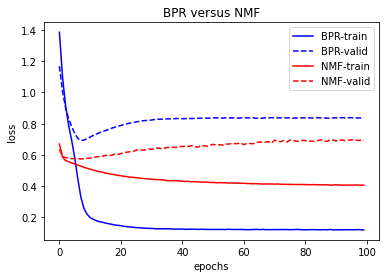

In [58]:
plt.title('BPR versus NMF')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(bpr_train_losses, 'b-', label='BPR-train')
plt.plot(bpr_valid_losses, 'b--', label='BPR-valid')
plt.plot(nmf_train_losses, 'r-', label='NMF-train')
plt.plot(nmf_valid_losses, 'r--', label='NMF-valid')
plt.legend()

By the experiment results, NMF performs better than BPR. Note that the training data for BPR is different, so its training loss is not comparable to others. The results may vary if we further adjust the hyperparameter configurations or the sampling strategy in BPR.

## Question 4

In [56]:
class CandidateGeneration(nn.Module):
    def __init__(self, config):
        super().__init__()
       
        # hyper-parameters
        self.config = config
        self.emb_dim = config['emb_dim']
        self.nb_users = config['user_cnts']
        self.nb_items = config['item_cnts']
        self.nb_genders = config['gender_cnts']
        self.nb_age_groups = config['age_group_cnts']
        self.nb_occupations = config['occupation_cnts']

        # embedding layers
        self.emb_item = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_dim)
        self.emb_gender = nn.Embedding(num_embeddings=self.nb_genders, embedding_dim=self.emb_dim)
        self.emb_age_group = nn.Embedding(num_embeddings=self.nb_age_groups, embedding_dim=self.emb_dim)
        self.emb_occupation = nn.Embedding(num_embeddings=self.nb_occupations, embedding_dim=self.emb_dim)

        # mlp layer
        layers = []
        in_dim = 4 * self.emb_dim + 1
        self.hidden_dims = config['hidden_dims']
        for out_dim in self.hidden_dims:
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.ReLU(inplace=True))
            in_dim = out_dim
        self.mlp = nn.Sequential(*layers)

    def forward(self, user_dict):

        # compute watch vector
        emb_watch = self.emb_item(user_dict['watched_history'])             # (batch_size, history_size, embed_dim)
        watch_vec = emb_watch.mean(1)                                       # (batch_size, embed_dim)

        # compute demographic embeddings
        emb_gender = self.emb_gender(user_dict['gender'])                   # (batch_size, embed_dim)
        emb_age_group = self.emb_age_group(user_dict['age_group'])          # (batch_size, embed_dim)
        emb_occupation = self.emb_occupation(user_dict['emb_occupation'])   # (batch_size, embed_dim)

        # adjust the shape of example age
        ea = user_dict['example_age'].view(-1, 1)                           # (batch_size, 1)

        # concat them and feed into the MLP
        feats = (watch_vec, emb_gender, emb_age_group, emb_occupation, ea)
        emb_user = torch.cat(feats, dim=1)                                  # (batch_size, 4*embed_dim+1)
        u = self.mlp(emb_user)                                              # (batch_size, embed_dim)

        # fetch item embeddings
        v = self.emb_item(torch.arange(self.nb_items))                      # (item_size, embed_dim)

        # compute the prediction matrix
        pred = F.softmax(u @ v.t(), dim=1)                                  # (batch_size, item_size)

        return pred
